Import MDAnalysis Module (https://www.mdanalysis.org/) and Matplotlib <br/> 
Don't forget to add the permissions: <br/>
sudo jupyter-nbextension enable nglview --py --sys-prefix <br/>
sudo  jupyter-nbextension enable --py widgetsnbextension <br/>

In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
import matplotlib
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

In [2]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import


name = '_DIM'

path = '/home/julie/analysis/bilayers/PM_5DIM/'
path_data = path
path_res = '/home/julie/analysis/bilayers/res_DIM/'
fgro = 'run_PM_5DIM.gro'
fxtc = 'run_PM_5DIM_s10_center_droplet2.xtc'

Load xtc and gro files using mda.Universe('struct file','traj file')

In [3]:
u = mda.Universe( path_data+fgro, path_data+fxtc)

In [4]:
# number of frames
len(u.trajectory)

2501

In [5]:
sel_all = u.select_atoms("all")

In [6]:
# select the atoms in the membrane and divide the bilayer into 2 leaflets selecting the species you want

sel_tot = "all and name PO4"


u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 2432
number of lipids in the upper leaflet: 1216 + number of lipids in the lower leaflet:1216 
= 2432


In [7]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all, gui=True)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

A Jupyter Widget

from nglview.contrib.movie import MovieMaker
#movie = MovieMaker(v, output='my.gif')
moviepy_params = {'codec': 'mpeg4'}
movie = MovieMaker(v, output='my.avi', in_memory=True)
movie.make()
movie.make()

In [8]:
# select the different species and set the x and y min and max values

patch = u.select_atoms(sel_tot).positions
print(patch)

Lo = leaflet0.select_atoms("name PO4 and resname POPC").positions
Ld = leaflet0.select_atoms("name PO4 and resname POPE").positions
chol = u.select_atoms("name ROH").positions


xmax = max(patch[:,0])
ymax = max(patch[:,1])
#dmax = int(min(xmax,ymax))
print(xmax)
print(ymax)

xmin = min(patch[:,0])
ymin = min(patch[:,1])

print(xmin)
print(ymin)

[[269.2      13.9     102.5    ]
 [ 33.6     276.8     103.3    ]
 [124.1     220.20001 110.99999]
 ...
 [179.7     248.9      60.     ]
 [263.59998  56.1      49.2    ]
 [157.2     200.1      39.1    ]]
287.4
286.9
-3.7
-4.2


In [9]:
print(np.mean(Lo[:,2]))
print(np.mean(Ld[:,2]))

95.302635
94.054825


In [69]:
# set the number of boxes into which will be divided the membrane

N = 13
dx = (xmax-xmin)/N
dy = (ymax-ymin)/N
print(dx)
print(dy)

22.392308161808895
22.392308161808895


In [120]:
# TAKE THE LAST FRAME

u.trajectory[1400]

< Timestep 1400 with unit cell dimensions [284.93503 284.93503 107.40541  90.       90.       90.     ] >

(169, 3)


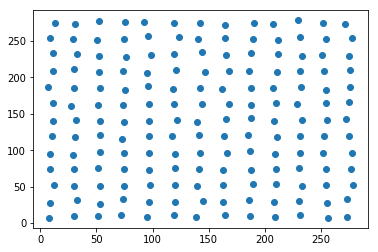

In [121]:
# leaflet 0
# divide the leaflet into a grid and calculate the concentration ratio in each box

bary0 = []
#del Mphi0
empty0 = 0

Mphi0_Lo = np.zeros((N,N))
Mphi0_Ld = np.zeros((N,N))

for i in range(0,N):
    xs = xmin + i*dx
    for j in range(0,N):
        ys = ymin + j*dy
        
        # barycenter of all molecules in each box
        str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
        b0=leaflet0.select_atoms(str_sel).centroid().tolist()
        bary0.append(b0)
        
        # composition rates in each box
        sel_tot= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
        tot0= leaflet0.select_atoms(sel_tot).positions
        n_tot0=len(tot0) # total number of molecules
        
        sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
        tot0PC= leaflet0.select_atoms(sel_totPC).positions
        n_tot0PC=len(tot0PC) # total number of PO4
        
        sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname POPC"
        Lo0= leaflet0.select_atoms(sel_Lo).positions
        n_Lo0=len(Lo0) # number of molecules of the Lo phase
        
        sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname POPE"
        Ld0= leaflet0.select_atoms(sel_Ld).positions
        n_Ld0=len(Ld0) # number of molecules of the Ld phase
        
        
        if  n_tot0PC!=0:
            phi0_Lo=n_Lo0/n_tot0PC
            phi0_Ld=n_Ld0/n_tot0PC
        
        else :
            empty0 += 1
            print('leaflet 0, empty box: i=%d and j=%d' % (i,j))
        
        Mphi0_Lo[i,j]=phi0_Lo
        Mphi0_Ld[i,j]=phi0_Ld
        
        
bary0=np.array(bary0)

plt.scatter(bary0[:,0],bary0[:,1])

print(np.shape(bary0))

(169, 3)


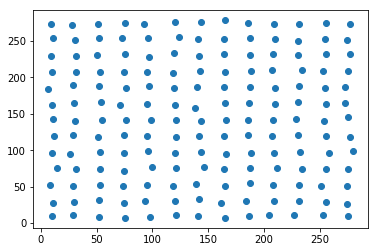

In [122]:
# leaflet 1
# divide the leaflet into a grid and calculate the concentration ratio in each box

bary1 = []
#del Mphi1
empty1 = 0

Mphi1_Lo = np.zeros((N,N))
Mphi1_Ld = np.zeros((N,N))

for i in range(0,N):
    xs = xmin + i*dx
    for j in range(0,N):
        ys = ymin + j*dy
        
        # barycenter of all molecules in each box
        str_sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
        b1=leaflet1.select_atoms(str_sel).centroid().tolist()
        bary1.append(b1)
        
        # composition rates in each box
        sel_tot= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
        tot1= leaflet1.select_atoms(sel_tot).positions
        n_tot1=len(tot1) # total number of molecules
        
        sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
        tot1PC= leaflet1.select_atoms(sel_totPC).positions
        n_tot1PC=len(tot1PC) # total number of PO4
        
        sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname POPC"
        Lo1= leaflet1.select_atoms(sel_Lo).positions
        n_Lo1=len(Lo1) # number of molecules of the Lo phase
        
        sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname POPE"
        Ld1= leaflet1.select_atoms(sel_Ld).positions
        n_Ld1=len(Ld1) # number of molecules of the Ld phase
        
        if  n_tot1PC!=0:
            phi1_Lo=n_Lo1/n_tot1PC
            phi1_Ld=n_Ld1/n_tot1PC
        
        else :
            empty1 += 1
            print('leaflet 1, empty box: i=%d and j=%d' % (i,j))
        
        Mphi1_Lo[i,j]=phi1_Lo
        Mphi1_Ld[i,j]=phi1_Ld
        
bary1=np.array(bary1)

plt.scatter(bary1[:,0],bary1[:,1])

print(np.shape(bary1))

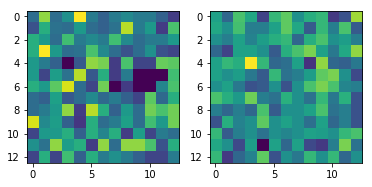

In [123]:
# leaflet 1

f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Mphi1_Ld)
ax2.imshow(Mphi1_Lo)

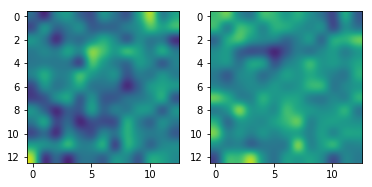

In [124]:
# leaflet 0

f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(Mphi0_Ld, interpolation='gaussian')
ax2.imshow(Mphi0_Lo, interpolation='gaussian')

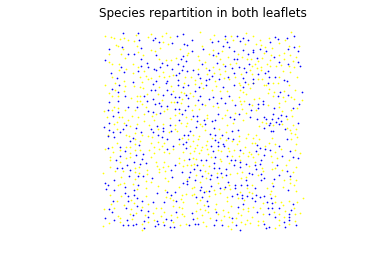

In [125]:
# plot the repartition of the different species

plt.scatter(Lo[:,1]/N, -Lo[:,0]/N, marker='.', c='yellow', s=2)
plt.scatter(Ld[:,1]/N, -Ld[:,0]/N, marker='.', c='b', s=2)

#plt.scatter(tot0[:,1]/N, -tot0[:,0]/N, marker='v', c='orange', s=2)
#plt.scatter(Ld0[:,1]/N, -Ld0[:,0]/N, marker='+', c='pink', s=2)
#plt.scatter(chol[:,1]/N, -chol[:,0]/N, marker='.', c='gray', s=2)

plt.axis('equal')
plt.axis('off')
plt.title('Species repartition in both leaflets',fontsize=12)
plt.savefig(path_res+'species'+name+'.pdf', format='pdf',bbox_inches='tight')

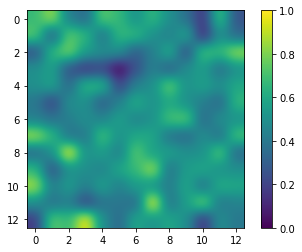

In [126]:
# leaflet 0
plt.imshow(Mphi0_Lo, interpolation='gaussian')
plt.colorbar()
plt.savefig(path_res+'compo-upperleaflet'+name+'.pdf', format='pdf',bbox_inches='tight')

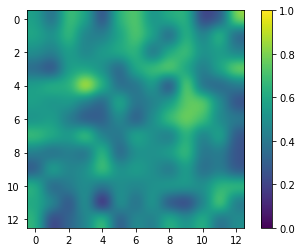

In [127]:
# leaflet 1
plt.imshow(Mphi1_Lo, interpolation='gaussian')
plt.colorbar()
plt.savefig(path_res+'compo-lowerleaflet'+name+'.pdf', format='pdf',bbox_inches='tight')

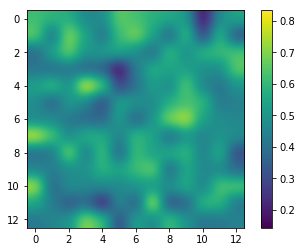

In [128]:
# mean composition of the two leaflets

Mphi_mean = (Mphi0_Lo+Mphi1_Lo)/2
plt.imshow(Mphi_mean, interpolation='gaussian')
plt.colorbar()

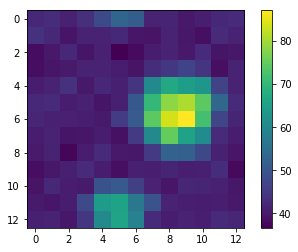

In [129]:
# compute the local thickness = the difference of z between the boxes of the 2 leaflets

bary0.shape=(N,N,3)
bary1.shape=(N,N,3)

diffz=bary0[:,:,2]-bary1[:,:,2]

bary0.shape=(N*N,3)
bary1.shape=(N*N,3)

plt.imshow(diffz)
plt.colorbar()
#plt.title('Epaisseur de la bicouche',fontsize=12)

plt.savefig(path_res+'thickness'+name+'.pdf', format='pdf',bbox_inches='tight')

In [130]:
diffz.shape=(N*N)

max_val = 0
max_ind = 0

for i in range(N*N):
    if(diffz[i])>=max_val:
        max_val = diffz[i]
        max_ind = i

max_ind_x = max_ind//N
max_ind_y = max_ind%N

print(max_ind_x)
print(max_ind_y)

diffz.shape=(N,N)

6
9


In [131]:
l_bubble = 7
r_bubble = np.int(np.floor(l_bubble/2))
M_bubble = np.zeros((l_bubble,l_bubble))
print(M_bubble)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [132]:
cpt = 0
for i in range(N):
    for j in range(N):
        if np.abs(i-max_ind_x)<=r_bubble and np.abs(j-max_ind_y)<=r_bubble :
            
            M_bubble[cpt//l_bubble, cpt%l_bubble] = diffz[i,j]
            cpt += 1

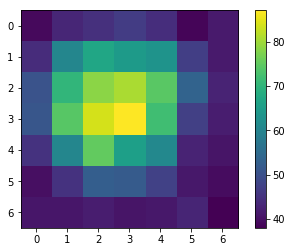

In [133]:
plt.imshow(M_bubble)
plt.colorbar()

In [134]:
mean_thickness = np.mean(diffz)
max_thickness = np.max(diffz)
min_thickness = np.min(diffz)
print('Mean thickness: %f\n Max thickness: %f\n Min thickness: %f\n' % (mean_thickness, max_thickness, min_thickness))

Mean thickness: 45.564864
 Max thickness: 87.144999
 Min thickness: 36.612503



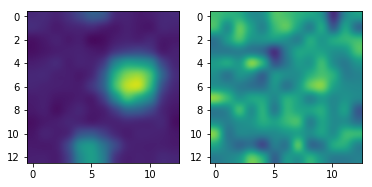

In [135]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(diffz, interpolation='gaussian')
ax2.imshow(Mphi_mean, interpolation='gaussian')


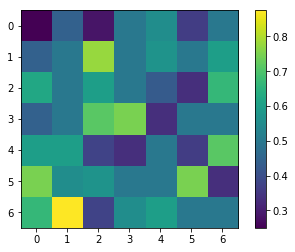

In [136]:
l_bubble = 7
r_bubble = np.int(np.floor(l_bubble/2))
M_bubble = np.zeros((l_bubble,l_bubble))
cpt = 0
for i in range(N):
    for j in range(N):
        if np.abs(i-max_ind_x)<=r_bubble and np.abs(j-max_ind_y)<=r_bubble :
            
            M_bubble[cpt//l_bubble, cpt%l_bubble] = Mphi0_Lo[i,j]
            cpt += 1
plt.imshow(M_bubble)
plt.colorbar()

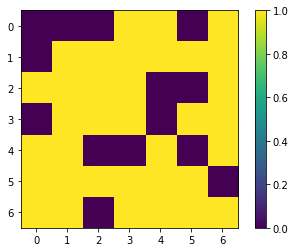

In [141]:
# leaflet binary composition

threshold = 0.50 # composition threshold from which the box is considered Lo, below it is considered Ld

Mphi0_bin = np.zeros((l_bubble,l_bubble))

for i in range(l_bubble):
    for j in range(l_bubble):
        if M_bubble[i,j]>= threshold :
            Mphi0_bin[i,j]=1          

plt.imshow(Mphi0_bin)
plt.colorbar()

In [142]:
# create the needed variable to calculate the local curvature

bary=bary0 
print(bary0[0,2])
print(bary1[0,2])
print(bary[0,2])

neigh = [0,0,0,0,0]
h=bary[:,2]

70.1500015258789
27.985713958740234
70.1500015258789


In [143]:
# define the function that gives the neighboring

def F_neigh(n) :
    neigh[0] = n
    i=n%N
    j=int(n/N)
    ip1=(i+1)%N
    im1=(i-1)%N
    jp1=(j+1)%N
    jm1=(j-1)%N
    neigh[1] = ip1+N*j
    neigh[2] = im1+N*j
    neigh[3] = i+N*jm1
    neigh[4] = i+N*jp1

In [144]:
# define the function that computes the discrete Laplacian in 2D (with 4 cross neighbors)

def Lap(n) :
    lap = ( h[neigh[4]]+h[neigh[3]]-2*h[neigh[0]] ) / dx**2 + ( h[neigh[1]]+h[neigh[2]]-2*h[neigh[0]] ) / dy**2
    return(lap)

In [145]:
# compute the local curvature in each box of the grid

laplacian = []
for i in range(N*N) :
    F_neigh(i)
    laplacian.append(Lap(i))

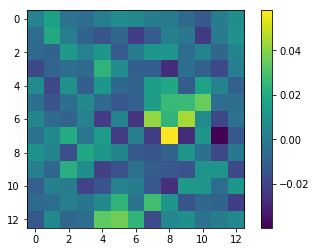

In [146]:
# create a matrix that contains local curvature for each box and scatter it

C = np.array(laplacian)
C.shape=(N,N)

plt.imshow(-C) # , interpolation='gaussian'
plt.colorbar()
#plt.title('Local curvature (medial leaflet)',fontsize=12)
plt.savefig(path_res+'local_curvature'+name+'.pdf', format='pdf',bbox_inches='tight')

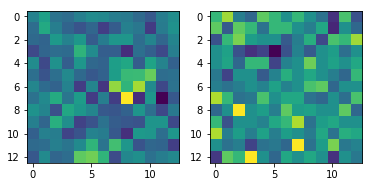

In [147]:
f, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(-C)
ax2.imshow(Mphi0_Lo)

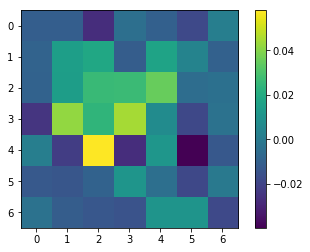

In [148]:
cpt = 0
for i in range(N):
    for j in range(N):
        if np.abs(i-max_ind_x)<=r_bubble and np.abs(j-max_ind_y)<=r_bubble :
            M_bubble[cpt//l_bubble, cpt%l_bubble] = -C[i,j]
            cpt += 1
            
plt.imshow(M_bubble)
plt.colorbar()

In [52]:
# correlation up-down leaflet composition
# compute the covariance

sum = 0
for i in range(0,N):
    for j in range(0,N):
        sum = sum + ( Mphi0_Lo[i,j]*Mphi1_Lo[i,j] - np.mean(Mphi0_Lo)*np.mean(Mphi1_Lo) ) / np.std(Mphi0_Lo)/np.std(Mphi1_Lo)
cov_phi = sum/N**2
print(cov_phi)     

-0.17747144222286781


In [53]:
# correlation composition - local thickness
# compute the covariance

sum = 0
for i in range(0,N):
    for j in range(0,N):
        sum = sum + ( Mphi_mean[i,j]*diffz[i,j] - np.mean(Mphi_mean)*np.mean(diffz) ) / np.std(Mphi_mean)/np.std(diffz)
cov_e = sum/N**2
print(cov_e)     

0.07745162781941796


In [54]:
# correlation composition - local curvature
# compute the covariance

sum = 0
for i in range(0,N):
    for j in range(0,N):
        sum = sum + ( C[i,j]*Mphi0_Lo[i,j] - np.mean(C)*np.mean(Mphi0_Lo) ) / np.std(C)/np.std(Mphi0_Lo)
cov_c = sum/N**2
print(cov_c)  

-0.1115903226260455


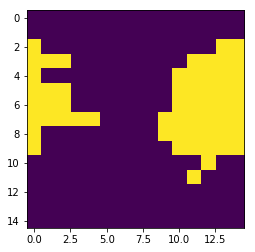

In [83]:
# upper leaflet binary composition

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

Mphi0_bin = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if Mphi0_Lo[i,j]>= threshold :
            Mphi0_bin[i,j]=1


#print(Mphi0_bin)          

plt.imshow(Mphi0_bin)

plt.savefig(path_res+'binary-compo_lower-upper_leaflet'+name+'.pdf', format='pdf',bbox_inches='tight')

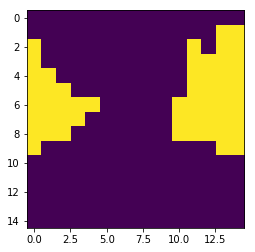

In [84]:
# lower leaflet binary composition

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

Mphi1_bin = np.zeros((N,N))

for i in range(N):
    for j in range(N):
        if Mphi1_Lo[i,j]>= threshold :
            Mphi1_bin[i,j]=1


#print(Mphi1_bin)          

plt.imshow(Mphi1_bin)

plt.savefig(path_res+'binary-compo_lower-lower_leaflet'+name+'.pdf', format='pdf',bbox_inches='tight')

In [85]:
# area ratio Lo / tot
area_ratio_Lo = np.sum(Mphi0_bin)/(N*N)
print(area_ratio_Lo)

0.2577777777777778


In [86]:
# Fraction of GM1 molecules located in the Lo phase

M_nb_GM1 = np.zeros((N,N))

for i in range(0,N):
    xs = xmin + i*dx
    for j in range(0,N):
        ys = ymin + j*dy
        
        # GM1 rates in each box        
        sel_GM1= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and name GM1"
        GM1_0= leaflet0.select_atoms(sel_GM1).positions
        n_GM1_0=len(GM1_0) # number of GM1 molecules        

        M_nb_GM1[i,j]=n_GM1_0
        
#print(M_nb_GM1)  
nb_GM1_tot = np.sum(M_nb_GM1)
print(nb_GM1_tot)

0.0


In [87]:
# rate of GM1 that are located in the Lo phase

M_GM1_Lo = Mphi0_bin*M_nb_GM1
#print(M_GM1_Lo)
nb_GM1_Lo = np.sum(M_GM1_Lo)
print(nb_GM1_Lo)
rate_GM1_Lo = nb_GM1_Lo/nb_GM1_tot
print(rate_GM1_Lo)

0.0
nan


In [88]:
# Lo boundary detection

Mphi0_bin.shape=(N*N)
M_bound_Lo = np.zeros((N*N))
neigh = [0,0,0,0,0]
for i in range(N*N) :
    F_neigh(i)
    if Mphi0_bin[i]==1 and (Mphi0_bin[i]!=Mphi0_bin[neigh[1]] or Mphi0_bin[i]!=Mphi0_bin[neigh[2]] or Mphi0_bin[i]!=Mphi0_bin[neigh[3]] or Mphi0_bin[i]!=Mphi0_bin[neigh[4]]):
        M_bound_Lo[i]=1
M_bound_Lo.shape=(N,N)
Mphi0_bin.shape=(N,N)
#print(M_bound_Lo)

In [89]:
# Ld boundary detection

Mphi0_bin.shape=(N*N)
M_bound_Ld = np.zeros((N*N))
neigh = [0,0,0,0,0]
for i in range(N*N) :
    F_neigh(i)
    if Mphi0_bin[i]==0 and (Mphi0_bin[i]!=Mphi0_bin[neigh[1]] or Mphi0_bin[i]!=Mphi0_bin[neigh[2]] or Mphi0_bin[i]!=Mphi0_bin[neigh[3]] or Mphi0_bin[i]!=Mphi0_bin[neigh[4]]):
        M_bound_Ld[i]=1
M_bound_Ld.shape=(N,N)
Mphi0_bin.shape=(N,N)
#print(M_bound_Ld)

30.0


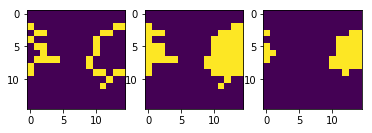

In [100]:
# Lo core

f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(M_bound_Lo)
ax2.imshow(Mphi0_bin)
ax3.imshow(Mphi0_bin-M_bound_Lo)

In [101]:
(xmax-xmin)/N

27.885335286458332

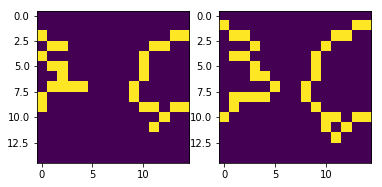

In [90]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(M_bound_Lo)
ax2.imshow(M_bound_Ld)

In [91]:
#M_bound=M_bound_Lo+M_bound_Ld
#plt.imshow(M_bound)

In [92]:
# area ratio Lo boundary / tot
area_ratio_Lobound = np.sum(M_bound_Lo)/(N*N)
print(area_ratio_Lobound)

0.12444444444444444


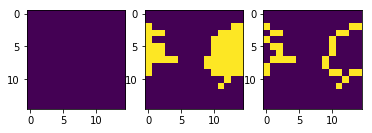

In [93]:
f, (ax1,ax2,ax3) = plt.subplots(1,3)
ax1.imshow(M_nb_GM1)
ax2.imshow(Mphi0_bin)
ax3.imshow(M_bound_Lo)
plt.savefig(path_res+'GM1locations_Lo_boundary'+name+'.pdf', format='pdf',bbox_inches='tight')

In [42]:
# Fraction of GM1 molecules located at the Lo boundary

M_GM1_bound_Lo = M_bound_Lo*M_nb_GM1
#print(M_GM1_bound_Lo)
nb_GM1_bound_Lo = np.sum(M_GM1_bound_Lo)
print(nb_GM1_bound_Lo)
rate_GM1_bound_Lo = nb_GM1_bound_Lo/nb_GM1_tot
print(rate_GM1_bound_Lo)

0.0
nan


In [43]:
M_GM1_Ld = (1-Mphi0_bin)*M_nb_GM1
nb_GM1_Ld = np.sum(M_GM1_Ld)
print(nb_GM1_Ld)
rate_GM1_Ld = nb_GM1_Ld/nb_GM1_tot
print(rate_GM1_Ld)

0.0
nan


In [44]:
# write these results to a file

file = open(path_res+'correl_coloc'+name+'.txt','w') 
file.write('correlation leaflet up-down: %lf\ncorrelation compo-thickness: %lf\ncorrelation compo-curvature: %lf\nFraction of GM1 molecules located in the Lo phase: %lf\nFraction of GM1 molecules located at the Lo boundary: %lf\nFraction of GM1 molecules located in the Lo phase / area ratio: %lf\nFraction of GM1 molecules located at the Lo boundary / area ratio: %lf' % (cov_phi, cov_e, cov_c, rate_GM1_Lo, rate_GM1_bound_Lo, rate_GM1_Lo/area_ratio_Lo, rate_GM1_bound_Lo/area_ratio_Lobound)) 
file.close() 